In [1]:
import math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mxnet import nd


from NeuralNet import NeuralNet
from Layer import Layer
from test_function import triangle
from activation import echelon, echelonSmooth

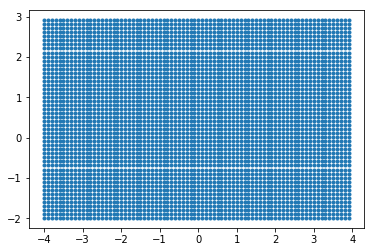

In [3]:
def generate_grid_test(limit, step = 10):
    Y_tmp = [x/step + 0.01 for x in range(-2*step,3*step, 1)] # +0.01 pour ne pas tomber pile sur la frontiere (pas terrible a l'affichage)
    n = len(Y_tmp)
    input_test = nd.zeros((2, n * 20 * limit))
    input_test[0] = nd.arange(-limit,limit,0.1,n)
    input_test[1] = nd.array(Y_tmp*20*limit)
    return input_test

input_test = generate_grid_test(4)
plt.plot(input_test[0].asnumpy(), input_test[1].asnumpy(), '.')
plt.show()

In [4]:
limit = 2
sample_size = limit * 100000

input_train = nd.zeros((2, sample_size))
input_train[0] = nd.random.uniform(-limit, limit, sample_size)
input_train[1] = nd.random.uniform(-1,2, sample_size)
input_test = nd.zeros((2, sample_size))
input_test[0] = nd.random.uniform(-limit, limit, sample_size)
input_test[1] = nd.random.uniform(-1,2, sample_size)

input_grid = generate_grid_test(2*limit)

output_train = triangle(input_train)
output_test = triangle(input_test)
output_grid = triangle(input_grid)

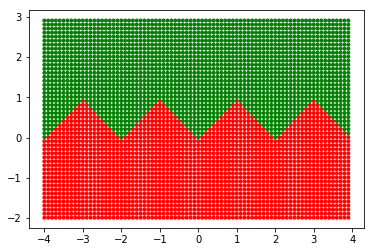

In [5]:
def plot2D(_input, output, title = ""):
    colors = ['red','green']
    plt.title(title)
    plt.scatter(_input[0].asnumpy(), _input[1].asnumpy(), c=output.asnumpy(), cmap=matplotlib.colors.ListedColormap(colors), marker = '.')
    plt.show()
    
plot2D(input_grid, output_grid)

In [6]:
## Generation d'un réseau faisant le taf
def generate_triangle_net(limit, norm_vect = None, optimize = True):
    n = math.ceil(math.log2(limit))

    if norm_vect is None:
        norm_vect = nd.array([1,0])
    sym = []
    sym.append((norm_vect,0))

    for i in range(n):
        sym.append((-norm_vect, 2**(n-i-1)))

    folder = NeuralNet.folding_net(sym, optimize = optimize)
    layers = [Layer(1,2, weights = nd.array([[-1, 1]]), bias = nd.array([0]), function = echelon)]
    computer = NeuralNet([2,1], layers)

    return folder + computer

triangle_net = generate_triangle_net(limit)

% de reussite : 1.0
Sizes : [2, 3, 3, 2, 1]


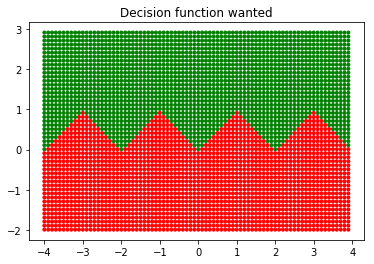

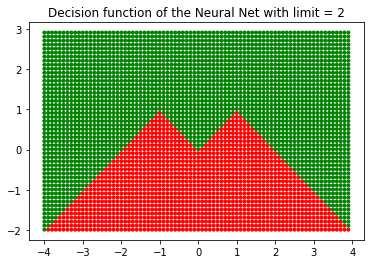

In [7]:
result_train = triangle_net.compute(input_train)
result_test = triangle_net.compute(input_test)
result_grid = triangle_net.compute(input_grid)

print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())
print("Sizes :", triangle_net.sizes)

plot2D(input_grid, output_grid, title = "Decision function wanted")
plot2D(input_grid, result_grid[0], title = "Decision function of the Neural Net with limit = " + str(limit))

# PARTIE I : Réseau random

In [8]:
name = "nets/PART1_limit" + str(limit) + ".net"

def generate_sized_net(net, delta_size):
    """Create a Decision Neural Net with inside function Relu.
    Take for sizes, the sizes of the argument net + delta_size. (only for inside layers).
    
    The net returned work therefore with the same input/output as the net given.
    """
    sizes = net.sizes.copy()
    for i in range(1, len(sizes)-1):
        sizes[i] += delta_size

    net = NeuralNet(sizes)
    for layer in net.layers[:-1]:
        layer.set_function(nd.relu)
    net.layers[-1].set_function(nd.sigmoid)
    return net

net = generate_sized_net(triangle_net, 1)



#TEST RANDOM BOF BOF
#net = NeuralNet([2,4,4,1])
#for layer in net.layers[:-1]:
#    layer.set_function(nd.relu)
#net.layers[-1].set_function(nd.sigmoid)
print("Sizes of net :", net.sizes)

Sizes of net : [2, 4, 4, 3, 1]


In [11]:
# net = NeuralNet.open(name)

In [49]:
train = net.train(input_train, output_train, epochs = 100, lr = 0.01, batch_size = limit * 10000)

Epochs 0: Pe = 0.046635 , loss = 0.032641
Epochs 1: Pe = 0.046655 , loss = 0.032589
Epochs 2: Pe = 0.046795 , loss = 0.032603
Epochs 3: Pe = 0.046810 , loss = 0.032661
Epochs 4: Pe = 0.046905 , loss = 0.032728
Epochs 5: Pe = 0.046815 , loss = 0.032602
Epochs 6: Pe = 0.047345 , loss = 0.032750
Epochs 7: Pe = 0.047220 , loss = 0.032747
Epochs 8: Pe = 0.047070 , loss = 0.032671
Epochs 9: Pe = 0.047060 , loss = 0.032709
Epochs 10: Pe = 0.046985 , loss = 0.032632
Epochs 11: Pe = 0.047035 , loss = 0.032603
Epochs 12: Pe = 0.046645 , loss = 0.032570
Epochs 13: Pe = 0.047285 , loss = 0.032719
Epochs 14: Pe = 0.047290 , loss = 0.032807
Epochs 15: Pe = 0.046835 , loss = 0.032586
Epochs 16: Pe = 0.046840 , loss = 0.032605
Epochs 17: Pe = 0.046755 , loss = 0.032558
Epochs 18: Pe = 0.046470 , loss = 0.032451
Epochs 19: Pe = 0.046640 , loss = 0.032523
Epochs 20: Pe = 0.046605 , loss = 0.032492
Epochs 21: Pe = 0.046700 , loss = 0.032584
Epochs 22: Pe = 0.046690 , loss = 0.032556
Epochs 23: Pe = 0.046

% de reussite : 0.99747


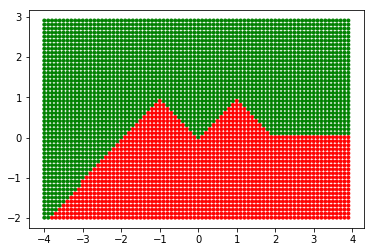

In [12]:
result_train = nd.round(net.compute(input_train))[0]
result_test = nd.round(net.compute(input_test))[0]
result_grid = nd.round(net.compute(input_grid))[0]
print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())

plot2D(input_grid, result_grid)

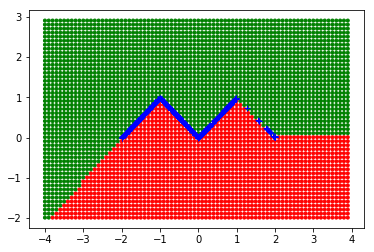

In [13]:
#cond = np.where(result_train.asnumpy() != output_train.asnumpy())
#plt.plot(input_train[0][cond].asnumpy(), input_train[1][cond].asnumpy(), '+', color = 'blue')
cond = np.where(result_test.asnumpy() != output_test.asnumpy())
plt.plot(input_test[0][cond].asnumpy(), input_test[1][cond].asnumpy(), '+', color = 'blue')
plot2D(input_grid, result_grid)

In [66]:
#net.save(name)

## PARTIE II : Réseau fixé, choix de certains parametres

In [14]:
triangle_net = generate_triangle_net(limit, optimize = False)
print(triangle_net.to_string())

//NeuralNet V1.2

//Sizes :
2 2 3 2 2 2 3 2 2 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
1.0 0.0 
0.0 1.0 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
0.0 0.0 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
1 1 1 

//Fixed weights :
1 1 
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
2 3

//Bias :
0.0 0.0 

//Weights :
1.0 1.0 0.0 
0.0 0.0 1.0 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
1 1 1 
1 1 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
1.0 0.0 
0.0 1.0 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
-1.0 -0.0 
-0.0 -1.0 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
-1.0 1.0 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.

## a)
Rotations completement libres

Bias completement libres mais initialement cohérents (égaux au bon signe pret) (Essai avec biais initialement libres non fonctionnel)

NON FONCTIONNEL

In [95]:
name = "nets/PART2a_limit" + str(limit) + ".net"
def generate_sym_net_2a(limit):
    n = math.ceil(math.log2(limit))
    
    layers = []
    sizes = [2]
    for i in range(n + 1): # n+ 1: fold /0 then /2**i
        # ROT random and changeable (Here it's only a matrix, not a rotanionnal one)
        layers.append(Layer(2, 2, bias = nd.zeros(2), function = nd.identity, fixed = nd.array([1,0,0])))
        sizes.append(2)
        
        # Folding Should be able to change the bias. (The bias should be the same in the 3 places, but the current NN does not allow us to do that)
        b = nd.random.normal(loc = 0, scale = 1, shape = 1)
        
        weights = nd.array([[-1.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
        bias = nd.zeros(3)
        bias[0] = b
        bias[1] = -b
        fixed = nd.array([[0, 1, 1], [0, 1, 1], [1, 1, 1]]) # all except the 2 first bias
        layers.append(Layer(3, 2, weights = weights, bias = bias, function = [nd.relu, nd.relu, nd.identity], fixed = fixed))
        sizes.append(3)
        
        weights = nd.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
        bias = nd.zeros(2)
        bias[0] = b
        fixed = nd.array([[0, 1, 1, 1], [1, 1, 1, 1]]) # All except the first bias
        layers.append(Layer(2,3, weights = weights, bias = bias, function = nd.identity, fixed = fixed))
        sizes.append(2)
        
    # ROT random and changeable (Here it's only a matrix, not a rotanionnal one)
    layers.append(Layer(2, 2, bias = nd.zeros(2), function = nd.identity, fixed = nd.array([1,0,0])))
    sizes.append(2)
    
    layers.append(Layer(1, 2, weights = nd.array([[-1, 1]]), bias = nd.array([0]), function = nd.sigmoid, fixed = True))
    sizes.append(1)
    
    return NeuralNet(sizes, layers)

sym_net = generate_sym_net_2a(limit)
print(sym_net.sizes)

[2, 2, 3, 2, 2, 3, 2, 2, 1]


In [ ]:
#net = NeuralNet.open(name)

In [96]:
train = sym_net.train(input_train, output_train, epochs = 150, lr = 0.01, batch_size = limit * 10000)

Epochs 0: Pe = 0.656935 , loss = 0.337514
Epochs 1: Pe = 0.553600 , loss = 0.263349
Epochs 2: Pe = 0.353200 , loss = 0.231616
Epochs 3: Pe = 0.249230 , loss = 0.221907
Epochs 4: Pe = 0.254750 , loss = 0.206894
Epochs 5: Pe = 0.257065 , loss = 0.186310
Epochs 6: Pe = 0.219405 , loss = 0.158615
Epochs 7: Pe = 0.161130 , loss = 0.123391
Epochs 8: Pe = 0.090250 , loss = 0.089300
Epochs 9: Pe = 0.077130 , loss = 0.068193
Epochs 10: Pe = 0.080030 , loss = 0.059730
Epochs 11: Pe = 0.080200 , loss = 0.056907
Epochs 12: Pe = 0.080525 , loss = 0.055937
Epochs 13: Pe = 0.080585 , loss = 0.055520
Epochs 14: Pe = 0.080705 , loss = 0.055313
Epochs 15: Pe = 0.080640 , loss = 0.055169
Epochs 16: Pe = 0.080615 , loss = 0.055042
Epochs 17: Pe = 0.080365 , loss = 0.054908
Epochs 18: Pe = 0.080025 , loss = 0.054753
Epochs 19: Pe = 0.079345 , loss = 0.054582
Epochs 20: Pe = 0.078565 , loss = 0.054407
Epochs 21: Pe = 0.078130 , loss = 0.054246
Epochs 22: Pe = 0.077800 , loss = 0.054092
Epochs 23: Pe = 0.077

% de reussite : 0.93182


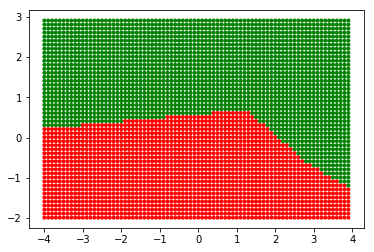

In [102]:
result_train = nd.round(sym_net.compute(input_train))[0]
result_test = nd.round(sym_net.compute(input_test))[0]
result_grid = nd.round(sym_net.compute(input_grid))[0]
print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())

plot2D(input_grid, result_grid)

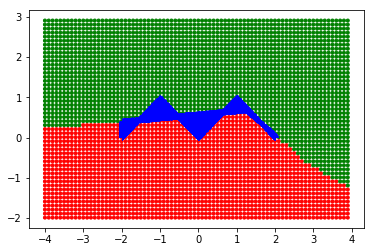

In [103]:
## PLOT ERRORS

#cond = np.where(result_train.asnumpy() != output_train.asnumpy())
#plt.plot(input_train[0][cond].asnumpy(), input_train[1][cond].asnumpy(), '+', color = 'blue')
cond = np.where(result_test.asnumpy() != output_test.asnumpy())
plt.plot(input_test[0][cond].asnumpy(), input_test[1][cond].asnumpy(), '+', color = 'blue')
plot2D(input_grid, result_grid)

In [20]:
print(sym_net.to_string())

//NeuralNet V1.2

//Sizes :
2 2 3 2 2 3 2 2 3 2 2 3 2 2 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
-0.16411613 -0.04774001 
0.00050960976 -1.2176229 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
0 0 
0 0 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
-1.3725576 -1.7046959 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
0 0 1 

//Fixed weights :
1 1 
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
2 3

//Bias :
-1.6249985 0.0 

//Weights :
1.0 1.0 0.0 
0.0 0.0 1.0 

//Functions :
identity

//Fixed bias : 
0 1 

//Fixed weights :
1 1 1 
1 1 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
-1.0422118 -1.8861974 
-1.0448476 -0.25999016 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
0 0 
0 0 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
-1.0513476 -0.33429626 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
0 0

In [ ]:
#net.save(name)

## b)
Rotation fixes -> on apprend le triangle horizontale, donc non necessaire

Bias libre mais initialement cohérents

In [113]:
name = "nets/PART2b_limit" + str(limit) + ".net"
def generate_sym_net_2b(limit):
    n = math.ceil(math.log2(limit))
    
    layers = []
    sizes = [2]
    for i in range(n + 1): # n+ 1: fold /0 then /2**i
        # Folding Should be able to change the bias. (The bias should be the same in the 3 places, but the current NN does not allow us to do that)
        b = nd.random.normal(loc = 0, scale = 1, shape = 1)
        
        weights = nd.array([[-1.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
        bias = nd.zeros(3)
        bias[0] = b
        bias[1] = -b
        fixed = nd.array([[0, 1, 1], [0, 1, 1], [1, 1, 1]]) # all except the 2 first bias
        layers.append(Layer(3, 2, weights = weights, bias = bias, function = [nd.relu, nd.relu, nd.identity], fixed = fixed))
        sizes.append(3)
        
        weights = nd.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
        bias = nd.zeros(2)
        bias[0] = b
        fixed = nd.array([[0, 1, 1, 1], [1, 1, 1, 1]]) # All except the first bias
        layers.append(Layer(2,3, weights = weights, bias = bias, function = nd.identity, fixed = fixed))
        sizes.append(2)
        
    
    layers.append(Layer(1, 2, weights = nd.array([[-1, 1]]), bias = nd.array([0]), function = nd.sigmoid, fixed = True))
    sizes.append(1)
    
    return NeuralNet(sizes, layers)

sym_net = generate_sym_net_2b(limit)
print(sym_net.sizes)

[2, 3, 2, 3, 2, 1]


In [ ]:
#net = NeuralNet.open(name)

In [117]:
train = sym_net.train(input_train, output_train, epochs = 150, lr = 0.1, batch_size = limit * 10000)

Epochs 0: Pe = 0.061595 , loss = 0.120076
Epochs 1: Pe = 0.062275 , loss = 0.120167
Epochs 2: Pe = 0.061390 , loss = 0.120137
Epochs 3: Pe = 0.062270 , loss = 0.120094
Epochs 4: Pe = 0.061630 , loss = 0.120132
Epochs 5: Pe = 0.060640 , loss = 0.120092
Epochs 6: Pe = 0.061525 , loss = 0.120141
Epochs 7: Pe = 0.063205 , loss = 0.120202
Epochs 8: Pe = 0.062640 , loss = 0.120163
Epochs 9: Pe = 0.061025 , loss = 0.120115
Epochs 10: Pe = 0.061360 , loss = 0.120099
Epochs 11: Pe = 0.063110 , loss = 0.120204
Epochs 12: Pe = 0.062125 , loss = 0.120178
Epochs 13: Pe = 0.061255 , loss = 0.120176
Epochs 14: Pe = 0.062175 , loss = 0.120150
Epochs 15: Pe = 0.061220 , loss = 0.120128
Epochs 16: Pe = 0.060930 , loss = 0.120074
Epochs 17: Pe = 0.061730 , loss = 0.120127
Epochs 18: Pe = 0.062765 , loss = 0.120175
Epochs 19: Pe = 0.063525 , loss = 0.120268
Epochs 20: Pe = 0.063460 , loss = 0.120266
Epochs 21: Pe = 0.062405 , loss = 0.120246
Epochs 22: Pe = 0.062890 , loss = 0.120254
Epochs 23: Pe = 0.062

% de reussite : 0.917245


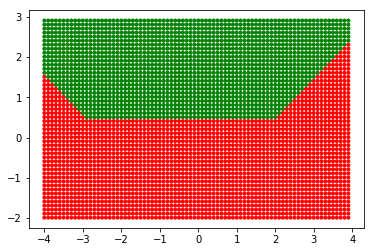

In [111]:
result_train = nd.round(sym_net.compute(input_train))[0]
result_test = nd.round(sym_net.compute(input_test))[0]
result_grid = nd.round(sym_net.compute(input_grid))[0]
print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())

plot2D(input_grid, result_grid)

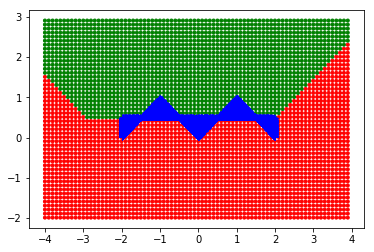

In [112]:
## PLOT ERRORS

#cond = np.where(result_train.asnumpy() != output_train.asnumpy())
#plt.plot(input_train[0][cond].asnumpy(), input_train[1][cond].asnumpy(), '+', color = 'blue')
cond = np.where(result_test.asnumpy() != output_test.asnumpy())
plt.plot(input_test[0][cond].asnumpy(), input_test[1][cond].asnumpy(), '+', color = 'blue')
plot2D(input_grid, result_grid)

In [115]:
print(sym_net.to_string())

//NeuralNet V1.2

//Sizes :
2 3 2 3 2 1 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
-1.0050623 1.0050807 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
0 0 1 

//Fixed weights :
1 1 
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
2 3

//Bias :
-1.6845986 0.0 

//Weights :
1.0 1.0 0.0 
0.0 0.0 1.0 

//Functions :
identity

//Fixed bias : 
0 1 

//Fixed weights :
1 1 1 
1 1 1 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
1.3344811 1.0245937 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
0 0 1 

//Fixed weights :
1 1 
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
2 3

//Bias :
-1.9594601 0.0 

//Weights :
1.0 1.0 0.0 
0.0 0.0 1.0 

//Functions :
identity

//Fixed bias : 
0 1 

//Fixed weights :
1 1 1 
1 1 1 

/LAYER
//Layer V1.3

//Sizes :
1 2

//Bias :
0.0 

//Weights :
-1.0 1.0 

//Functions :
sigmoid

//Fixed bias : 
1 

//Fixed weights :
1 1 




In [116]:
#net.save(name)

## c)
Biais fixes (correctes)

rotations complètement libres (non cohérentes)

In [27]:
name = "nets/PART2c_limit" + str(limit) + ".net"
def generate_sym_net_2a(limit):
    n = math.ceil(math.log2(limit))
    
    layers = []
    sizes = [2]
    b = [0] + [2**i for i in range(n-1, -1, -1)]
    for i in range(n + 1): # n+ 1: fold /0 then /2**i
        # ROT random and changeable (Here it's only a matrix, not a rotanionnal one)
        layers.append(Layer(2, 2, bias = nd.zeros(2), function = nd.identity, fixed = nd.array([1,0,0])))
        sizes.append(2)
        
        # Folding All is fixed
        
        weights = nd.array([[-1.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
        bias = nd.zeros(3)
        bias[0] = -b[i]
        bias[1] = b[i]
        layers.append(Layer(3, 2, weights = weights, bias = bias, function = [nd.relu, nd.relu, nd.identity], fixed = True))
        sizes.append(3)
        
        weights = nd.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
        bias = nd.zeros(2)
        bias[0] = -b[i]
        layers.append(Layer(2,3, weights = weights, bias = bias, function = nd.identity, fixed = True))
        sizes.append(2)
        
    # ROT random and changeable (Here it's only a matrix, not a rotanionnal one)
    layers.append(Layer(2, 2, bias = nd.zeros(2), function = nd.identity, fixed = nd.array([1,0,0])))
    sizes.append(2)
    
    layers.append(Layer(1, 2, weights = nd.array([[-1, 1]]), bias = nd.array([0]), function = nd.sigmoid, fixed = True))
    sizes.append(1)
    
    return NeuralNet(sizes, layers)

sym_net = generate_sym_net_2a(limit)
print(sym_net.sizes)

[2, 2, 3, 2, 2, 3, 2, 2, 1]


In [28]:
train = sym_net.train(input_train, output_train, epochs = 150, lr = 0.1, batch_size = limit * 10000)

Epochs 0: Pe = 0.279510 , loss = 0.184484
Epochs 1: Pe = 0.102900 , loss = 0.078750
Epochs 2: Pe = 0.094715 , loss = 0.073523
Epochs 3: Pe = 0.089410 , loss = 0.067766
Epochs 4: Pe = 0.084255 , loss = 0.059200
Epochs 5: Pe = 0.077925 , loss = 0.054602
Epochs 6: Pe = 0.073795 , loss = 0.051151
Epochs 7: Pe = 0.065575 , loss = 0.046631
Epochs 8: Pe = 0.050155 , loss = 0.037653
Epochs 9: Pe = 0.023990 , loss = 0.025605
Epochs 10: Pe = 0.018985 , loss = 0.021144
Epochs 11: Pe = 0.011775 , loss = 0.017324
Epochs 12: Pe = 0.013995 , loss = 0.016194
Epochs 13: Pe = 0.008055 , loss = 0.013965
Epochs 14: Pe = 0.007495 , loss = 0.013066
Epochs 15: Pe = 0.009625 , loss = 0.012859
Epochs 16: Pe = 0.010480 , loss = 0.012498
Epochs 17: Pe = 0.005815 , loss = 0.011193
Epochs 18: Pe = 0.006920 , loss = 0.010960
Epochs 19: Pe = 0.005860 , loss = 0.010476
Epochs 20: Pe = 0.006250 , loss = 0.010221
Epochs 21: Pe = 0.010170 , loss = 0.010780
Epochs 22: Pe = 0.007900 , loss = 0.010110
Epochs 23: Pe = 0.005

% de reussite : 0.997085


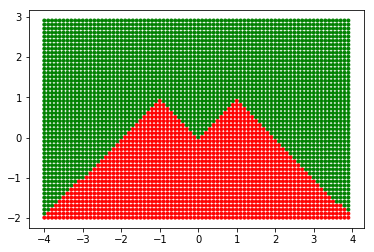

In [29]:
result_train = nd.round(sym_net.compute(input_train))[0]
result_test = nd.round(sym_net.compute(input_test))[0]
result_grid = nd.round(sym_net.compute(input_grid))[0]
print("% de reussite :", (nd.sum(result_test==output_test)/output_test.shape[0]).asscalar())

plot2D(input_grid, result_grid)

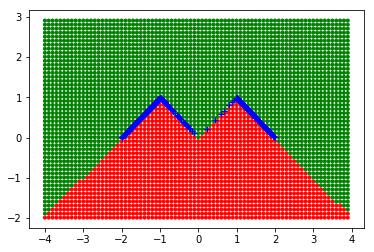

In [30]:
## PLOT ERRORS

#cond = np.where(result_train.asnumpy() != output_train.asnumpy())
#plt.plot(input_train[0][cond].asnumpy(), input_train[1][cond].asnumpy(), '+', color = 'blue')
cond = np.where(result_test.asnumpy() != output_test.asnumpy())
plt.plot(input_test[0][cond].asnumpy(), input_test[1][cond].asnumpy(), '+', color = 'blue')
plot2D(input_grid, result_grid)

In [31]:
print(sym_net.to_string())

//NeuralNet V1.2

//Sizes :
2 2 3 2 2 3 2 2 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
2.5747736 -0.007275887 
-0.0006872956 -2.985094 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
0 0 
0 0 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
0.0 0.0 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
1 1 1 

//Fixed weights :
1 1 
1 1 
1 1 

/LAYER
//Layer V1.3

//Sizes :
2 3

//Bias :
0.0 0.0 

//Weights :
1.0 1.0 0.0 
0.0 0.0 1.0 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
1 1 1 
1 1 1 

/LAYER
//Layer V1.3

//Sizes :
2 2

//Bias :
0.0 0.0 

//Weights :
-1.0308981 -0.54728234 
2.2503207 3.1199474 

//Functions :
identity

//Fixed bias : 
1 1 

//Fixed weights :
0 0 
0 0 

/LAYER
//Layer V1.3

//Sizes :
3 2

//Bias :
-1.0 1.0 0.0 

//Weights :
-1.0 0.0 
1.0 0.0 
0.0 1.0 

//Functions :
relu relu identity 

//Fixed bias : 
1 1 1 

//Fixed weights :
1 1 
1 1 
1 1 

/LAYER
//Lay

In [32]:
net.save(name)